# Figures for plotting

In [1]:
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis
#Simulator
###### Simulate
headers = ["k1" , "k2", "k3"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 38.94801652652866, 'k2': 193.4015439096185, 'k3': 52.24130352947285, 
              'n1': 4.758094367378883, 'n2': 1.985417765709296, 'n3': 4.910007465597671, 
              'dm1': 1.1977430229572492, 'dm2': 1.5302375124759988, 'dm3': 1.5608364378206137, 
              'dp1': 0.7747339528650133, 'dp2': 0.7511393265314563, 'dp3': 0.7528339378453786,
              'a1': 30.52123007653054, 'a2': 39.231588311273846, 'a3': 34.86007101736975, 
              'g1': 0.1902661176643755, 'g2': 0.28113643328037285, 'g3': 0.8181176651249633, 
              'b1': 24.68491191280538, 'b2': 29.42387320898578, 'b3': 41.04934603816582}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param


def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
        yt = torch.tensor(y, dtype=torch.float32).T.flatten()
        return yt.unsqueeze(-1)
    return solve_ode(theta, t)
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2]),
    high=torch.tensor([250.,250.,250.]))
true_params = tuple(param_dict[parameter] for parameter in headers)

def my_simulator_t(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]
    def solve_ode_t(params, t):
        seed = 12
        np.random.seed(seed)
        initial_conditions = np.array([0.0, 2.0, 0.0, 1.0, 0.0, 3.0])
        solution = odeint(model, initial_conditions, t, args=(params,))
        noise = solution * 0.05
        solution += np.random.normal(0, noise)
        y = np.maximum(solution, 0)
        yt = torch.tensor(y, dtype=torch.float32).T.flatten()
        return yt.unsqueeze(-1)
    return solve_ode_t(theta, t)
    


In [ ]:
def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)
        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]


def solve_ode_t(params, t):
    seed = 12
    np.random.seed(seed)
    initial_conditions = np.array([0.0, 2.0, 0.0, 1.0, 0.0, 3.0])
    solution = odeint(model, initial_conditions, t, args=(params,))
    noise = solution * 0.05
    solution += np.random.normal(0, noise)
    y = np.maximum(solution, 0)
    yt = torch.tensor(y, dtype=torch.float32).T.flatten()
    return yt.unsqueeze(-1)



In [7]:
true_data = my_simulator_t(true_params)
true_data

tensor([[0.0000e+00],
        [3.3636e+00],
        [1.1766e+00],
        [4.2175e-01],
        [2.3052e-01],
        [1.8177e-01],
        [1.7572e-01],
        [3.3928e-01],
        [9.8522e-01],
        [4.1967e+00],
        [8.6247e+00],
        [7.8906e+00],
        [3.9340e+00],
        [1.1998e+00],
        [5.2452e-01],
        [2.4981e-01],
        [1.9574e-01],
        [1.6793e-01],
        [1.9099e-01],
        [2.1600e-01],
        [6.6915e-01],
        [2.5153e+00],
        [6.8109e+00],
        [9.3035e+00],
        [5.9559e+00],
        [1.7900e+00],
        [7.2808e-01],
        [3.3064e-01],
        [1.9813e-01],
        [1.7235e-01],
        [1.5625e-01],
        [1.8171e-01],
        [3.1332e-01],
        [1.3082e+00],
        [4.9460e+00],
        [9.6335e+00],
        [7.9353e+00],
        [3.3579e+00],
        [1.0216e+00],
        [4.5390e-01],
        [2.4650e-01],
        [1.9613e-01],
        [1.6261e-01],
        [1.7205e-01],
        [2.2065e-01],
        [7

In [21]:
true_plot = true_data.reshape(6,100).T
true_plot

tensor([[0.0000e+00, 1.9319e+00, 0.0000e+00, 9.1496e-01, 0.0000e+00, 2.7698e+00],
        [3.3636e+00, 8.3121e+01, 1.2176e+01, 2.6214e+02, 6.8260e+00, 2.4295e+02],
        [1.1766e+00, 6.6429e+01, 1.1016e+01, 3.3570e+02, 4.2295e+00, 2.3574e+02],
        [4.2175e-01, 4.6627e+01, 9.6164e+00, 3.6891e+02, 1.0145e+01, 3.1225e+02],
        [2.3052e-01, 2.2685e+01, 4.8907e+00, 2.9262e+02, 1.6484e+01, 5.6286e+02],
        [1.8177e-01, 1.5194e+01, 2.5617e+00, 2.2060e+02, 2.1556e+01, 8.7730e+02],
        [1.7572e-01, 9.7341e+00, 1.4402e+00, 1.3852e+02, 2.1986e+01, 1.0528e+03],
        [3.3928e-01, 8.8514e+00, 1.0287e+00, 8.9145e+01, 2.2678e+01, 1.2850e+03],
        [9.8522e-01, 1.6319e+01, 9.1276e-01, 6.5603e+01, 2.1521e+01, 1.3303e+03],
        [4.1967e+00, 5.1527e+01, 8.5771e-01, 4.5810e+01, 1.9857e+01, 1.1947e+03],
        [8.6247e+00, 1.3711e+02, 1.0306e+00, 4.2654e+01, 6.1798e+00, 9.0368e+02],
        [7.8906e+00, 2.2917e+02, 2.0450e+00, 4.8967e+01, 1.6882e+00, 5.1996e+02],
        [3.9340e

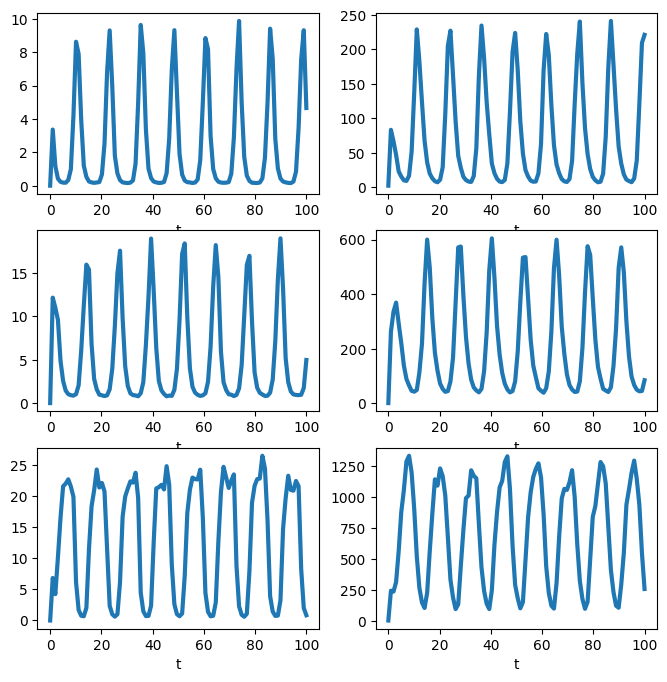

In [23]:
# Plot real trajectories and also accepted trajectories, they overlap
true_plot = true_data.reshape(6,100).T
fig, axs = plt.subplots(3,2, figsize=(8,8))
axs = axs.flatten()
for i in range(6):    
    axs[i].plot(t, true_plot[:, i], label='True Data', linewidth=3)
    axs[i].set_xlabel('t')
plt.show()

What is the simulator outputting?

In [26]:
###### Simulate
headers = ["k1" , "k2", "k3"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 38.94801652652866, 'k2': 193.4015439096185, 'k3': 52.24130352947285, 
              'n1': 4.758094367378883, 'n2': 1.985417765709296, 'n3': 4.910007465597671, 
              'dm1': 1.1977430229572492, 'dm2': 1.5302375124759988, 'dm3': 1.5608364378206137, 
              'dp1': 0.7747339528650133, 'dp2': 0.7511393265314563, 'dp3': 0.7528339378453786,
              'a1': 30.52123007653054, 'a2': 39.231588311273846, 'a3': 34.86007101736975, 
              'g1': 0.1902661176643755, 'g2': 0.28113643328037285, 'g3': 0.8181176651249633, 
              'b1': 24.68491191280538, 'b2': 29.42387320898578, 'b3': 41.04934603816582}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
        yt = torch.tensor(y, dtype=torch.float32).T.flatten()
        return yt.unsqueeze(-1)
    return solve_ode(theta, t)
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2]),
    high=torch.tensor([250.,250.,250.]))
true_params = tuple(param_dict[parameter] for parameter in headers)
simulator_wrapper, prior = prepare_for_sbi(my_simulator, prior)



In [27]:
true_params

(38.94801652652866, 193.4015439096185, 52.24130352947285)

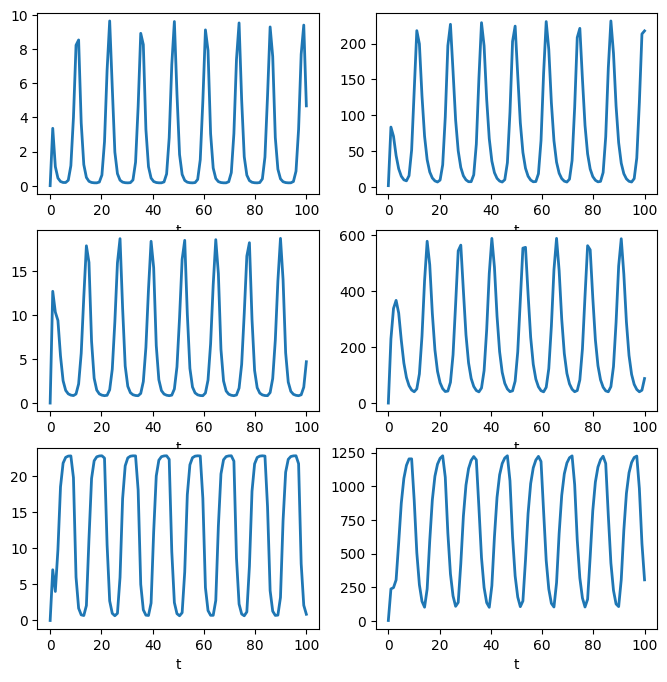

In [33]:
true_wrap = simulator_wrapper(torch.tensor(true_params).unsqueeze(0))
true_wrap_plot = true_wrap.squeeze(0).reshape(6,100).T
fig, axs = plt.subplots(3,2, figsize=(8,8))
axs = axs.flatten()
for i in range(6):    
    axs[i].plot(t, true_wrap_plot[:, i], label='True Data', linewidth=2)
    axs[i].set_xlabel('t')
plt.show()

In [34]:
true_wrap2 = my_simulator(true_params)
true_wrap2

tensor([[0.0000e+00],
        [3.3627e+00],
        [1.1155e+00],
        [4.4464e-01],
        [2.4464e-01],
        [1.8670e-01],
        [1.8494e-01],
        [3.1804e-01],
        [1.1692e+00],
        [3.9967e+00],
        [8.2362e+00],
        [8.5437e+00],
        [3.6753e+00],
        [1.2352e+00],
        [4.8058e-01],
        [2.5488e-01],
        [1.8756e-01],
        [1.6780e-01],
        [1.6578e-01],
        [2.1124e-01],
        [6.2181e-01],
        [2.5777e+00],
        [6.7694e+00],
        [9.6573e+00],
        [5.7636e+00],
        [1.9712e+00],
        [7.0224e-01],
        [3.2107e-01],
        [2.0728e-01],
        [1.7344e-01],
        [1.6453e-01],
        [1.7670e-01],
        [3.3501e-01],
        [1.3741e+00],
        [4.6420e+00],
        [8.9324e+00],
        [8.2701e+00],
        [3.2953e+00],
        [1.1111e+00],
        [4.4336e-01],
        [2.4377e-01],
        [1.8425e-01],
        [1.6687e-01],
        [1.6628e-01],
        [2.2029e-01],
        [6

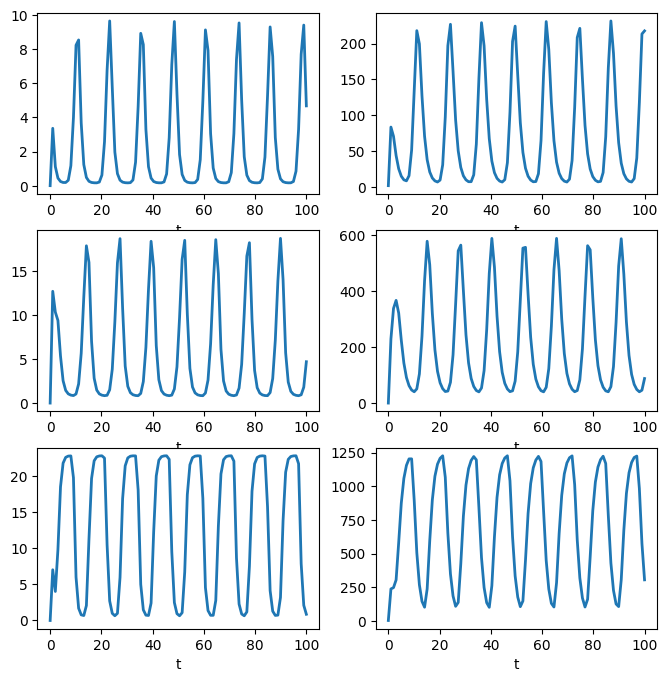

In [35]:
true_wrap2 = my_simulator(true_params)
true_wrap_plot2 = true_wrap2.squeeze(0).reshape(6,100).T
fig, axs = plt.subplots(3,2, figsize=(8,8))
axs = axs.flatten()
for i in range(6):    
    axs[i].plot(t, true_wrap_plot2[:, i], label='True Data', linewidth=2)
    axs[i].set_xlabel('t')
plt.show()

params?

In [36]:
#Simulator
###### Simulate
headers = ["k1" , "k2", "k3"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 38.94801652652866, 'k2': 193.4015439096185, 'k3': 52.24130352947285, 
              'n1': 4.758094367378883, 'n2': 1.985417765709296, 'n3': 4.910007465597671, 
              'dm1': 1.1977430229572492, 'dm2': 1.5302375124759988, 'dm3': 1.5608364378206137, 
              'dp1': 0.7747339528650133, 'dp2': 0.7511393265314563, 'dp3': 0.7528339378453786,
              'a1': 30.52123007653054, 'a2': 39.231588311273846, 'a3': 34.86007101736975, 
              'g1': 0.1902661176643755, 'g2': 0.28113643328037285, 'g3': 0.8181176651249633, 
              'b1': 24.68491191280538, 'b2': 29.42387320898578, 'b3': 41.04934603816582}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
        yt = torch.tensor(y, dtype=torch.float32).T.flatten()
        return yt.unsqueeze(-1)
    return solve_ode(theta, t)
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2]),
    high=torch.tensor([250.,250.,250.]))
true_params = tuple(param_dict[parameter] for parameter in headers)


def my_simulator_t(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]
    def solve_ode_t(params, t):
        seed = 12
        np.random.seed(seed)
        initial_conditions = np.array([0.0, 2.0, 0.0, 1.0, 0.0, 3.0])
        solution = odeint(model, initial_conditions, t, args=(params,))
        noise = solution * 0.05
        solution += np.random.normal(0, noise)
        y = np.maximum(solution, 0)
        yt = torch.tensor(y, dtype=torch.float32).T.flatten()
        return yt.unsqueeze(-1)
    return solve_ode_t(theta, t)
    
true_data = my_simulator_t(true_params)
num_dim = len(true_params)
simulator_wrapper, prior = prepare_for_sbi(my_simulator, prior)

In [37]:
true_params

(38.94801652652866, 193.4015439096185, 52.24130352947285)